In [ ]:
import os
import re
import numpy as np
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error



In [ ]:
service = Service(ChromeDriverManager().install())
options = Options()
driver = webdriver.Chrome(service=service, options=options)

# Data Scraping
This code scarp the Booking.com and get 50,000 records to predict the ratings using other categoies

In [ ]:
if not os.path.exists('data.csv'):
    records = []
    for page_index in range(1, 2001):
        print(page_index)
        offset = page_index * 25
        url = f'https://www.booking.com/searchresults.html?aid=304142&ss=United+States+of+America&ssne=United+States+of+America&ssne_untouched=United+States+of+America&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=224&dest_type=country&checkin=2022-06-16&checkout=2022-06-17&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&changed_currency=1&selected_currency=USD&top_currency=1&offset={offset}'

        driver.get(url)
        try:
            cards = WebDriverWait(driver, 60).until(EC.presence_of_all_elements_located((By.XPATH, '//div[@data-testid="property-card"]')))
            
            for card in cards:
                '''
                title = card.find_element(By.XPATH, './/div[@data-testid="title"]').text
                address = card.find_element(By.XPATH, './/span[@data-testid="address"]').text
                '''       
                review_text = card.find_element(By.XPATH, './/div[@data-testid="review-score"]').text
                review_text = review_text.split('\n')
                rating = float(review_text[0])
                review = review_text[1]
                num_review = int(re.findall(r'\d+', review_text[2])[0])
                
                price = card.find_elements(By.XPATH, './/div[@data-testid="price-and-discounted-price"]/span')[-1].text
                price = int(re.findall(r'\d+', price)[0])
                
                taxies = card.find_element(By.XPATH, './/div[@data-testid="taxes-and-charges"]').text
                try:
                    taxies = int(re.findall(r'\d+', taxies)[0])
                except:
                    taxies = 0
                
                rating_stars = len(card.find_elements(By.XPATH, './/div[@data-testid="rating-stars"]/span'))

                records.append([review, num_review, price, taxies, rating_stars, rating])
        except ValueError:
            break
    driver.quit()
    
    # Convert scraped data to dataframe and save as csv file
    df = pd.DataFrame (records, columns = ['Review', 'Number of Reviews', 'Price', 'Tax', 'Star', 'Rating'])
    df.to_csv('data.csv', index = False)  

*Load dataset from csv file*

In [47]:
df = pd.read_csv('data.csv')
df.head()

,Review,Number of Reviews,Price,Tax,Star,Rating
0,Excellent,887,134,12,3,8.9
1,Exceptional,6,180,14,0,9.7
2,Excellent,476,105,12,0,8.7
3,Very Good,308,104,14,3,8.2
4,Very Good,109,130,14,3,8.5


# Pre-Processing

*Drop NAN Values*

In [48]:
df =df.dropna()
df.head()

,Review,Number of Reviews,Price,Tax,Star,Rating
0,Excellent,887,134,12,3,8.9
1,Exceptional,6,180,14,0,9.7
2,Excellent,476,105,12,0,8.7
3,Very Good,308,104,14,3,8.2
4,Very Good,109,130,14,3,8.5


*Statistical analysis of dataframe*

In [49]:
df.describe()

,Number of Reviews,Price,Tax,Star,Rating
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,214.937060,143.464560,18.472620,2.572320,8.147386
std,161.973667,47.036757,9.224918,0.705223,0.623883
min,1.000000,1.000000,0.000000,0.000000,4.900000
25%,108.000000,109.000000,13.000000,2.000000,7.700000
50%,181.000000,139.000000,17.000000,3.000000,8.200000
75%,260.000000,169.000000,22.000000,3.000000,8.600000
max,960.000000,855.000000,718.000000,5.000000,10.000000


# EDA

*Bar-plot of number of reviews*

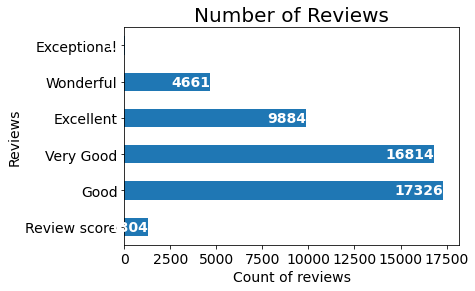

In [50]:
review_names = ['Review score', 'Good', 'Very Good', 'Excellent', 'Wonderful', 'Exceptional']
review_count = df['Review'].value_counts()
review_count = review_count[review_names]

# plot labels indicating the number of leagues
for i, value in enumerate(review_count):
     plt.text(value, i, str(value), horizontalalignment='right', verticalalignment='center', weight='bold', color='white', fontsize=14)

# plot the results using an horizontal bar plot
review_count.plot(kind='barh')

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Count of reviews', fontsize=14)
plt.ylabel('Reviews', fontsize=14)
plt.title('Number of Reviews', fontsize=20);

*Bar-plot of number of stars*

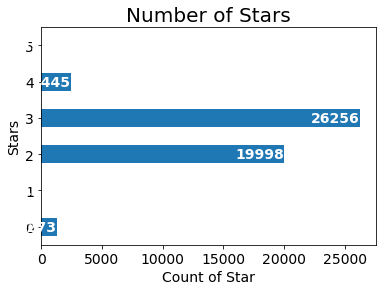

In [51]:
star_names = [0, 1, 2, 3, 4, 5]
star_count = df['Star'].value_counts()
star_count = star_count[star_names]

# plot labels indicating the number of leagues
for i, value in enumerate(star_count):
     plt.text(value, i, str(value), horizontalalignment='right', verticalalignment='center', weight='bold', color='white', fontsize=14)

# plot the results using an horizontal bar plot
star_count.plot(kind='barh')

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Count of Star', fontsize=14)
plt.ylabel('Stars', fontsize=14)
plt.title('Number of Stars', fontsize=20);

*Convert string reviews to numerical values*

In [52]:
mymap = {'Review score':1, 'Good':2, 'Very Good':3, 'Excellent':4, 'Wonderful':5, 'Exceptional':6}
df = df.applymap(lambda s: mymap.get(s) if s in mymap else s)
df.head()

,Review,Number of Reviews,Price,Tax,Star,Rating
0,4,887,134,12,3,8.9
1,6,6,180,14,0,9.7
2,4,476,105,12,0,8.7
3,3,308,104,14,3,8.2
4,3,109,130,14,3,8.5


*Statistical analysis*

In [53]:
df.describe()

,Review,Number of Reviews,Price,Tax,Star,Rating
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.986100,214.937060,143.464560,18.472620,2.572320,8.147386
std,1.011537,161.973667,47.036757,9.224918,0.705223,0.623883
min,1.000000,1.000000,1.000000,0.000000,0.000000,4.900000
25%,2.000000,108.000000,109.000000,13.000000,2.000000,7.700000
50%,3.000000,181.000000,139.000000,17.000000,3.000000,8.200000
75%,4.000000,260.000000,169.000000,22.000000,3.000000,8.600000
max,6.000000,960.000000,855.000000,718.000000,5.000000,10.000000


*Correlation analysis*

In [54]:
df.corr(method ='pearson')

,Review,Number of Reviews,Price,Tax,Star,Rating
Review,1.000000,-0.062132,0.271392,0.208119,0.077291,0.934610
Number of Reviews,-0.062132,1.000000,0.122223,0.049933,0.075991,-0.034195
Price,0.271392,0.122223,1.000000,0.647589,0.245654,0.332610
Tax,0.208119,0.049933,0.647589,1.000000,0.215567,0.256035
Star,0.077291,0.075991,0.245654,0.215567,1.000000,0.111017
Rating,0.934610,-0.034195,0.332610,0.256035,0.111017,1.000000


# Predict Rating using Linear Regression

*Split datset to train and test*

In [55]:
X = df[['Review', 'Number of Reviews', 'Price', 'Tax', 'Star']]
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

*Build Linear Regression model using train datasets*

In [56]:
linear_reg_rank = linear_model.LinearRegression()
linear_reg_rank.fit(X_train, y_train)

LinearRegression()

*Predict rating using linear regression model for test dataset*

In [57]:
yhat = linear_reg_rank.predict(X_test)
MAE = mean_absolute_error(y_test, yhat)
RMSE = np.sqrt(mean_squared_error(y_test, yhat))
print("MAE: {}, RMSE: {}" .format(MAE, RMSE))

MAE: 0.17651280381492057, RMSE: 0.21476114865334756


In [58]:
df_test = X_test
df_test['Rating'] = y_test
df_test['Predict'] = yhat
df_test['Diff(%)'] = abs(df_test['Rating'] - df_test['Predict']) / df_test['Rating'] * 100
df_test

,Review,Number of Reviews,Price,Tax,Star,Rating,Predict,Diff(%)
33553,4,257,169,15,3,8.6,8.745537,1.692290
9427,2,143,204,25,3,7.9,7.658901,3.051888
199,4,228,255,31,3,8.9,8.838640,0.689438
12447,3,305,167,18,3,8.0,8.187239,2.340491
39489,3,133,150,22,3,8.1,8.169219,0.854555
...,...,...,...,...,...,...,...,...
27615,3,219,242,28,4,8.0,8.277684,3.471054
21964,3,242,180,25,3,8.5,8.203956,3.482874
33321,2,241,139,15,2,7.6,7.577841,0.291560
40225,2,114,66,10,2,7.0,7.501941,7.170592


*Corss-Validation*

In [60]:
cross_MAE = []
cross_RMSE = []
for i in range(5):
    # split data to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    # fit linear regression model
    linear_reg_rank.fit(X_train, y_train)
    
    # predict rating
    yhat = linear_reg_rank.predict(X_test)
    
    # compute MAE and RMSE
    MAE = mean_absolute_error(y_test, yhat)
    cross_MAE.append(MAE)
    
    RMSE = np.sqrt(mean_squared_error(y_test, yhat))
    cross_RMSE.append(RMSE)
    print("MAE: {}, RMSE: {}" .format(MAE, RMSE))

MAE: 0.17777835352405166, RMSE: 0.21593646957725113
MAE: 0.17855699421348442, RMSE: 0.21596057025732632
MAE: 0.17816544028590423, RMSE: 0.21647272854374314
MAE: 0.17836951063103296, RMSE: 0.21663265549615632
MAE: 0.17660655465592345, RMSE: 0.21397762609776075


*MAE of Cross Validation*

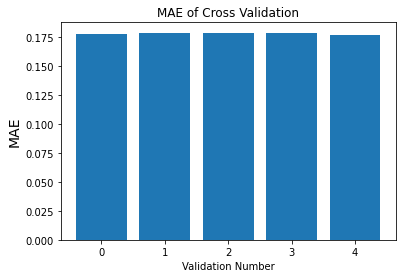

In [64]:
plt.bar(list(range(5)), cross_MAE)
plt.xlabel('Validation Number')
plt.ylabel('MAE', fontsize=14)
plt.title('MAE of Cross Validation');
plt.show()

*RMSE of Cross Validation*

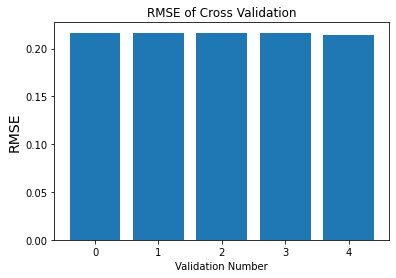

In [65]:
plt.bar(list(range(5)), cross_RMSE)
plt.xlabel('Validation Number')
plt.ylabel('RMSE', fontsize=14)
plt.title('RMSE of Cross Validation');
plt.show()